# 07 — Per-Zone Supply & Demand Analysis

**Now that we have price data** (via hvakosterstrommen.no), we can see the supply/demand balance in each zone.

## Why not just look at production/consumption?

Statnett only publishes **aggregate national** production and consumption — not per zone.
ENTSO-E has per-zone data, but we're waiting for the API key.

However, **prices ARE the supply/demand signal**. The day-ahead price is set by the market
clearing where supply meets demand. A high price means demand exceeds cheap supply.

## What we can show per zone

| Indicator | Source | What it tells us |
|-----------|--------|------------------|
| **Day-ahead price** | hvakosterstrommen.no | Supply/demand equilibrium (the target variable) |
| **Reservoir filling** | NVE | Available hydro supply (95% of Norwegian generation) |
| **Temperature** | Frost API | Heating demand driver (cold → more demand → higher price) |
| **Wind speed** | Frost API | Wind generation (more wind → more supply → lower price) |
| **Precipitation** | Frost API | Reservoir recharge signal (rain fills reservoirs → future supply) |

Together, these paint a clear picture of **why prices differ between zones**.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = str(Path.cwd().parent) if Path("../src").exists() else str(Path.cwd())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import logging

logging.basicConfig(level=logging.WARNING)  # Quiet during notebook use

ZONES = ["NO_1", "NO_2", "NO_3", "NO_4", "NO_5"]
ZONE_LABELS = {
    "NO_1": "Oslo", "NO_2": "Kristiansand",
    "NO_3": "Trondheim", "NO_4": "Tromsø", "NO_5": "Bergen",
}
ZONE_COLORS = {
    "NO_1": "tab:blue", "NO_2": "tab:orange",
    "NO_3": "tab:green", "NO_4": "tab:purple", "NO_5": "tab:red",
}

# Data available from Oct 2021 (hvakosterstrommen.no)
START = "2022-01-01"
END = "2026-01-01"

# --- EUR/NOK for price conversion ---
from src.data.fetch_fx import fetch_eur_nok_daily_filled

fx_data = fetch_eur_nok_daily_filled(START, END, cache=True)
AVG_EUR_NOK = fx_data["eur_nok"].mean()
print(f"EUR/NOK average ({START} to {END}): {AVG_EUR_NOK:.2f}")


def add_nok_axis(ax, eur_nok=None):
    """Add a secondary y-axis showing NOK/kWh alongside EUR/MWh.

    Scales the right y-axis proportionally using the average EUR/NOK rate.
    """
    rate = eur_nok if eur_nok is not None else AVG_EUR_NOK
    ax2 = ax.twinx()
    ymin, ymax = ax.get_ylim()
    ax2.set_ylim(ymin * rate / 1000, ymax * rate / 1000)
    ax2.set_ylabel("NOK/kWh", fontsize=9, color="gray")
    ax2.tick_params(axis="y", labelcolor="gray", labelsize=8)
    return ax2

EUR/NOK average (2022-01-01 to 2026-01-01): 11.22


---
## 1. Day-Ahead Prices — The Supply/Demand Equilibrium

Price = where supply meets demand. When the price is high in a zone, demand exceeds cheap supply there.

### How the day-ahead price is set (merit order)

The **Nord Pool day-ahead auction** works like this every day at 12:00 CET for the next day's 24 hours:

1. **Generators** submit bids: "I can produce X MWh at Y EUR/MWh" (sorted cheapest → most expensive)
2. **Consumers** submit bids: "I need X MWh and will pay up to Y EUR/MWh"
3. The **market clearing price** is where supply and demand curves intersect

```
Price
  ↑         Supply (merit order)
  |         ┌──────────  Gas/thermal (expensive)
  |     ┌───┘
  |  ┌──┘              Market clearing price ← ← ←
  |──┘  Hydro/Wind     ─ ─ ─ ─ ─ ─ ─ ─ ─ ─ ─
  |     (cheap)                    |
  |                    Demand curve ↘
  └──────────────────────────────────→ Quantity (MWh)
```

In Norway, hydro is the dominant supply (cheap, near-zero marginal cost). The price is set by the **marginal generator** — the most expensive unit needed to meet demand. When Norway is connected to Europe via cables, European gas prices can set the Norwegian price.

### What the plots below show

| Plot | What it tells us |
|------|------------------|
| **Price time series** (top) | Daily average prices for all 5 zones. The 2022 energy crisis is clearly visible. Southern zones (NO_1, NO_2, NO_5) are more expensive and volatile. |
| **Price spread** (bottom) | Difference between the most and least expensive zone each day. Large spreads = transmission congestion between zones. |
| **Box plot** | Price distribution — shows median, quartiles, and spread. NO_3/NO_4 are clearly cheaper. |
| **Monthly bars** | Seasonal price pattern — winter is more expensive (heating demand). |
| **Hourly pattern** | Daily price cycle — peaks at 8–9 AM and 17–18 PM when demand is highest. |
| **Weekday vs weekend** | Weekend prices are lower — industry and offices are closed. |

In [2]:
from src.data.fetch_nordpool import fetch_prices

prices = fetch_prices(START, END, cache=True)
print(f"Prices loaded: {prices.shape[0]:,} rows x {prices.shape[1]} zones")
print(f"Date range: {prices.index.min()} to {prices.index.max()}")
print(f"Missing values: {prices.isna().sum().sum()}")
print(f"\nAverage price by zone (EUR/NOK avg: {AVG_EUR_NOK:.2f}):")
print(f"  {'Zone':<22s} {'EUR/MWh':>10s} {'NOK/kWh':>10s}")
print(f"  {'-'*44}")
for zone in ZONES:
    if zone in prices.columns:
        avg_eur = prices[zone].mean()
        avg_nok_kwh = avg_eur * AVG_EUR_NOK / 1000
        print(f"  {zone} ({ZONE_LABELS[zone]:13s}): {avg_eur:8.1f}   {avg_nok_kwh:8.3f}")

Prices loaded: 35,088 rows x 5 zones
Date range: 2022-01-01 00:00:00+01:00 to 2026-01-01 23:00:00+01:00
Missing values: 4

Average price by zone (EUR/NOK avg: 11.22):
  Zone                      EUR/MWh    NOK/kWh
  --------------------------------------------
  NO_1 (Oslo         ):     89.9      1.009
  NO_2 (Kristiansand ):    101.5      1.139
  NO_3 (Trondheim    ):     32.5      0.364
  NO_4 (Tromsø       ):     21.6      0.243
  NO_5 (Bergen       ):     86.7      0.973


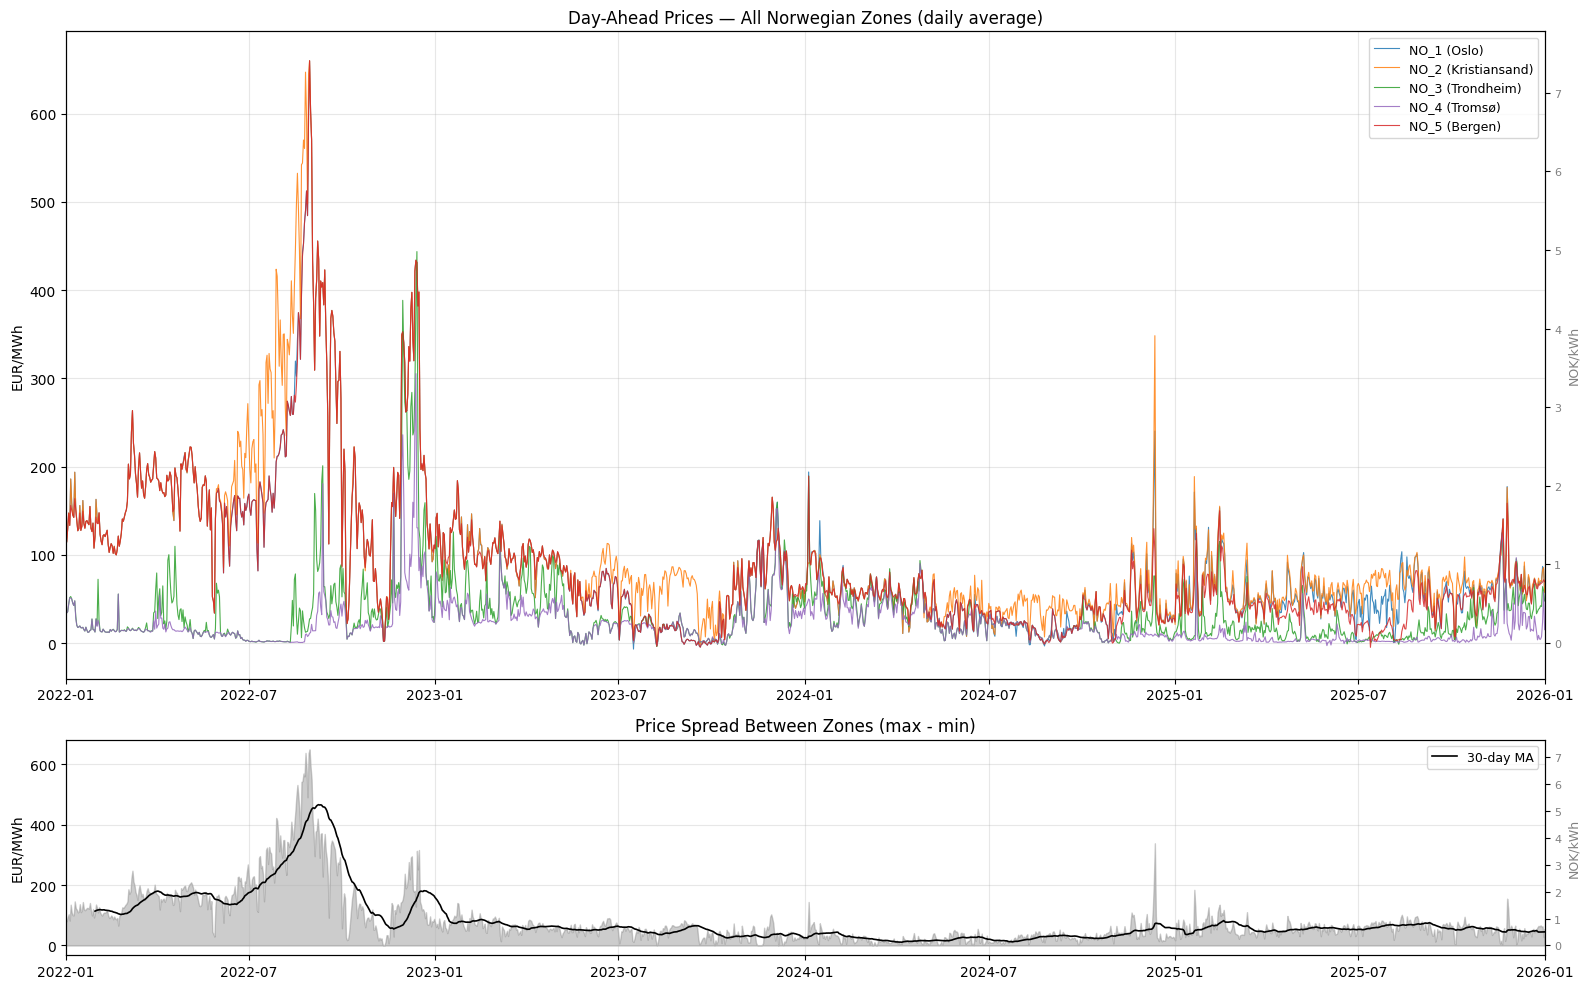

Average spread: 81.2 EUR/MWh (0.911 NOK/kWh)
Max spread: 649 EUR/MWh (7.28 NOK/kWh)

When the spread is large, zones are congested — transmission can't equalize prices.


In [3]:
# Daily average prices — all zones
daily_prices = prices.resample("D").mean()

fig, axes = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={"height_ratios": [3, 1]})

# Panel 1: price time series
ax = axes[0]
for zone in ZONES:
    if zone in daily_prices.columns:
        ax.plot(daily_prices.index, daily_prices[zone],
                color=ZONE_COLORS[zone], linewidth=0.8,
                label=f"{zone} ({ZONE_LABELS[zone]})", alpha=0.85)
ax.set_ylabel("EUR/MWh")
ax.set_title("Day-Ahead Prices — All Norwegian Zones (daily average)")
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(daily_prices.index.min(), daily_prices.index.max())
add_nok_axis(ax)

# Panel 2: price spread (max zone - min zone)
ax = axes[1]
spread = daily_prices.max(axis=1) - daily_prices.min(axis=1)
ax.fill_between(spread.index, 0, spread.values, color="grey", alpha=0.4)
ax.plot(spread.index, spread.rolling(30).mean(), color="black", linewidth=1.2, label="30-day MA")
ax.set_ylabel("EUR/MWh")
ax.set_title("Price Spread Between Zones (max - min)")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(daily_prices.index.min(), daily_prices.index.max())
add_nok_axis(ax)

plt.tight_layout()
plt.show()

avg_spread_nok = spread.mean() * AVG_EUR_NOK / 1000
print(f"Average spread: {spread.mean():.1f} EUR/MWh ({avg_spread_nok:.3f} NOK/kWh)")
print(f"Max spread: {spread.max():.0f} EUR/MWh ({spread.max() * AVG_EUR_NOK / 1000:.2f} NOK/kWh)")
print("\nWhen the spread is large, zones are congested — transmission can't equalize prices.")

/var/folders/_2/_llw2n8s67n_9kq4z4d57vvr0000gn/T/ipykernel_16000/3718614627.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, showfliers=False)


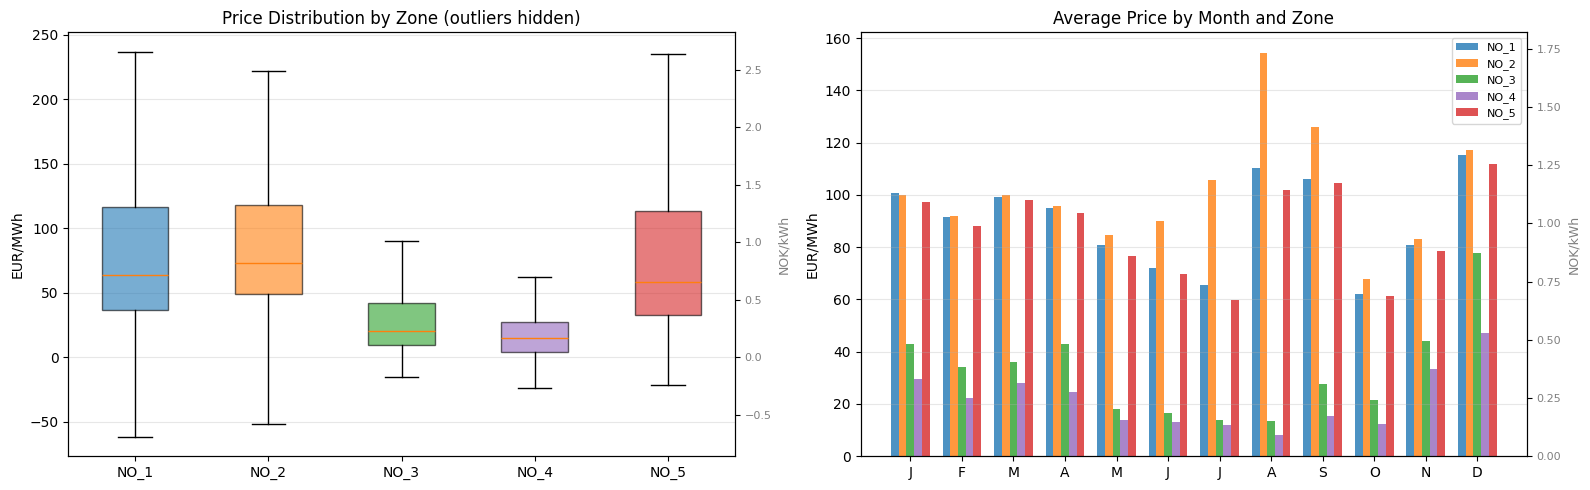

OBSERVATION: NO_3 and NO_4 are consistently cheaper — surplus hydro, fewer cable exports.
NO_1 and NO_2 track European prices more closely due to interconnectors.
(Right y-axis shows NOK/kWh at avg EUR/NOK = 11.22)


In [4]:
# Price distribution per zone
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Box plot
ax = axes[0]
data = [prices[z].dropna().values for z in ZONES if z in prices.columns]
labels = [z for z in ZONES if z in prices.columns]
bp = ax.boxplot(data, labels=labels, patch_artist=True, showfliers=False)
for i, patch in enumerate(bp["boxes"]):
    patch.set_facecolor(ZONE_COLORS[labels[i]])
    patch.set_alpha(0.6)
ax.set_ylabel("EUR/MWh")
ax.set_title("Price Distribution by Zone (outliers hidden)")
ax.grid(True, alpha=0.3, axis="y")
add_nok_axis(ax)

# Monthly average per zone
ax = axes[1]
month_labels = ["J","F","M","A","M","J","J","A","S","O","N","D"]
x = np.arange(12)
width = 0.15
for i, zone in enumerate(ZONES):
    if zone in prices.columns:
        monthly = prices[zone].groupby(prices.index.month).mean()
        ax.bar(x + i * width, monthly.values, width,
               color=ZONE_COLORS[zone], alpha=0.8, label=zone)
ax.set_xticks(x + width * 2)
ax.set_xticklabels(month_labels)
ax.set_ylabel("EUR/MWh")
ax.set_title("Average Price by Month and Zone")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, axis="y")
add_nok_axis(ax)

plt.tight_layout()
plt.show()

print("OBSERVATION: NO_3 and NO_4 are consistently cheaper — surplus hydro, fewer cable exports.")
print("NO_1 and NO_2 track European prices more closely due to interconnectors.")
print(f"(Right y-axis shows NOK/kWh at avg EUR/NOK = {AVG_EUR_NOK:.2f})")

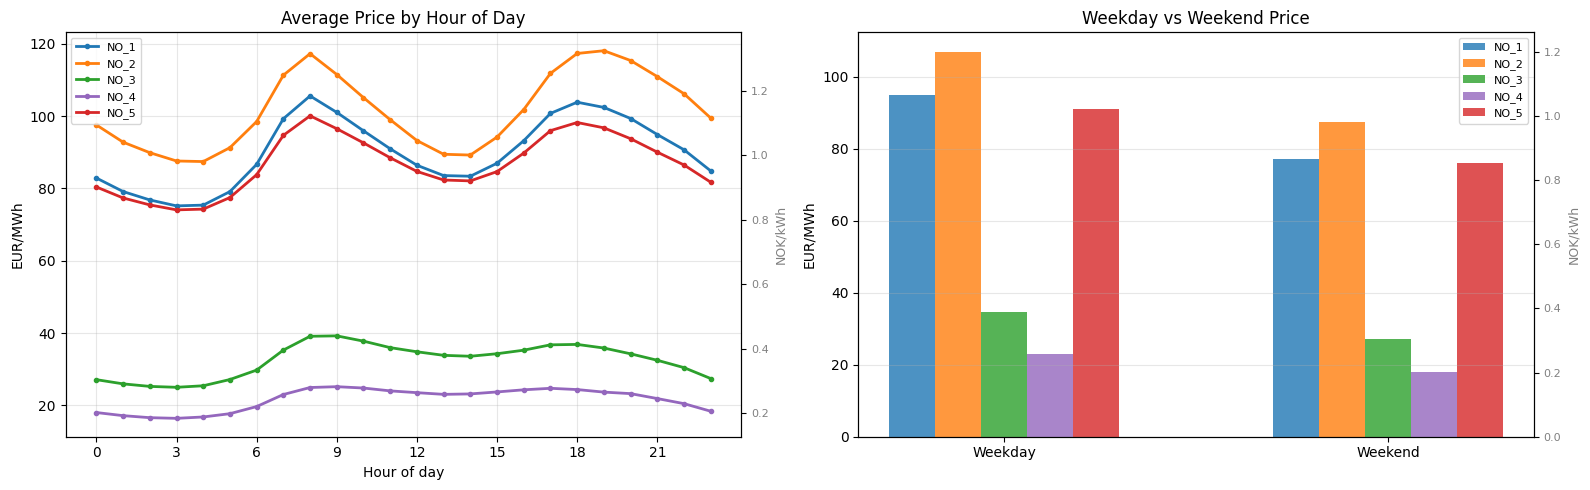

NO_2 weekday: 107.1 EUR/MWh (1.201 NOK/kWh)
NO_2 weekend: 87.6 EUR/MWh (0.983 NOK/kWh)
Weekend discount: 18%

Prices peak at 8-9 AM and 17-18 PM (morning and evening demand).
Weekend prices are lower — industry and offices are closed.


In [5]:
# Hourly price pattern — when is electricity most/least expensive?
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# By hour of day
ax = axes[0]
for zone in ZONES:
    if zone in prices.columns:
        hourly_avg = prices[zone].groupby(prices.index.hour).mean()
        ax.plot(hourly_avg.index, hourly_avg.values,
                color=ZONE_COLORS[zone], linewidth=2, marker="o", markersize=3,
                label=zone)
ax.set_xlabel("Hour of day")
ax.set_ylabel("EUR/MWh")
ax.set_title("Average Price by Hour of Day")
ax.set_xticks(range(0, 24, 3))
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
add_nok_axis(ax)

# Weekday vs weekend
ax = axes[1]
x = np.arange(2)
width = 0.12
for i, zone in enumerate(ZONES):
    if zone in prices.columns:
        is_weekend = prices.index.dayofweek >= 5
        weekday_avg = prices.loc[~is_weekend, zone].mean()
        weekend_avg = prices.loc[is_weekend, zone].mean()
        ax.bar(x + i * width, [weekday_avg, weekend_avg], width,
               color=ZONE_COLORS[zone], alpha=0.8, label=zone)
ax.set_xticks(x + width * 2)
ax.set_xticklabels(["Weekday", "Weekend"])
ax.set_ylabel("EUR/MWh")
ax.set_title("Weekday vs Weekend Price")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, axis="y")
add_nok_axis(ax)

plt.tight_layout()
plt.show()

# Show weekday/weekend in NOK/kWh too
if "NO_2" in prices.columns:
    is_wknd = prices.index.dayofweek >= 5
    wd = prices.loc[~is_wknd, "NO_2"].mean()
    we = prices.loc[is_wknd, "NO_2"].mean()
    print(f"NO_2 weekday: {wd:.1f} EUR/MWh ({wd*AVG_EUR_NOK/1000:.3f} NOK/kWh)")
    print(f"NO_2 weekend: {we:.1f} EUR/MWh ({we*AVG_EUR_NOK/1000:.3f} NOK/kWh)")
    print(f"Weekend discount: {(1 - we/wd)*100:.0f}%")
print("\nPrices peak at 8-9 AM and 17-18 PM (morning and evening demand).")
print("Weekend prices are lower — industry and offices are closed.")

---
## 2. Supply Side — Per Zone

Norway is ~95% hydro. The supply side is dominated by:
- **Reservoir levels** — how much water is available to generate electricity
- **Wind speed** — wind turbines add supply when it's windy
- **Precipitation** — rain refills reservoirs (future supply)

### Hydro reservoir economics

Hydro generators face a unique optimization problem: **when to use the water**.

$$V_{\text{water}}(t) = \max\Big(P_{\text{spot}}(t),\; \mathbb{E}[P_{\text{spot}}(t+\tau)]\Big) \times \eta \text{ (MWh/m³)}$$

where:
- $V_{\text{water}}$ = value of water (opportunity cost of using it now)
- $P_{\text{spot}}(t)$ = today's electricity price
- $\mathbb{E}[P_{\text{spot}}(t+\tau)]$ = expected future price
- $\eta$ = turbine efficiency (MWh generated per m³ of water)

**Key insight**: If producers expect winter prices to be high, they conserve water in autumn (bidding higher) → prices rise even before winter arrives. This is why reservoir **trajectory** (the rate of filling/draining) matters as much as the absolute level.

### NVE benchmarks

NVE provides 20-year historical min, max, and median filling levels per zone per week. The deviation from median is a key scarcity signal:

- **Below median**: Scarcity risk → water value rises → prices increase
- **Near minimum**: Emergency territory → extreme price spikes possible
- **Above median**: Comfortable supply → lower prices, risk of spillage (wasted water)

### What the plots below show

| Plot | What it tells us |
|------|------------------|
| **Reservoir per zone** (5 panels) | Filling % with 20-year median (dashed). Each zone has a different capacity and seasonal pattern. |
| **Wind speed** (time series) | Weekly average wind per zone. Coastal zones are windier. Wind adds zero-marginal-cost supply. |
| **Precipitation** (time series) | Weekly rainfall per zone. Bergen (NO_5) is famously wet — keeps its reservoirs healthier. |

In [6]:
from src.data.fetch_reservoir import fetch_zone_reservoir_with_benchmarks
from src.data.fetch_metro import fetch_zone_weather

reservoir = {}
weather = {}

for zone in ZONES:
    try:
        reservoir[zone] = fetch_zone_reservoir_with_benchmarks(zone, START, END, cache=True)
    except Exception as e:
        print(f"Reservoir {zone}: {e}")
    try:
        weather[zone] = fetch_zone_weather(zone, START, END, cache=True)
    except Exception as e:
        print(f"Weather {zone}: {e}")

print(f"Reservoir data: {len(reservoir)}/{len(ZONES)} zones")
print(f"Weather data: {len(weather)}/{len(ZONES)} zones")

Reservoir data: 5/5 zones
Weather data: 5/5 zones


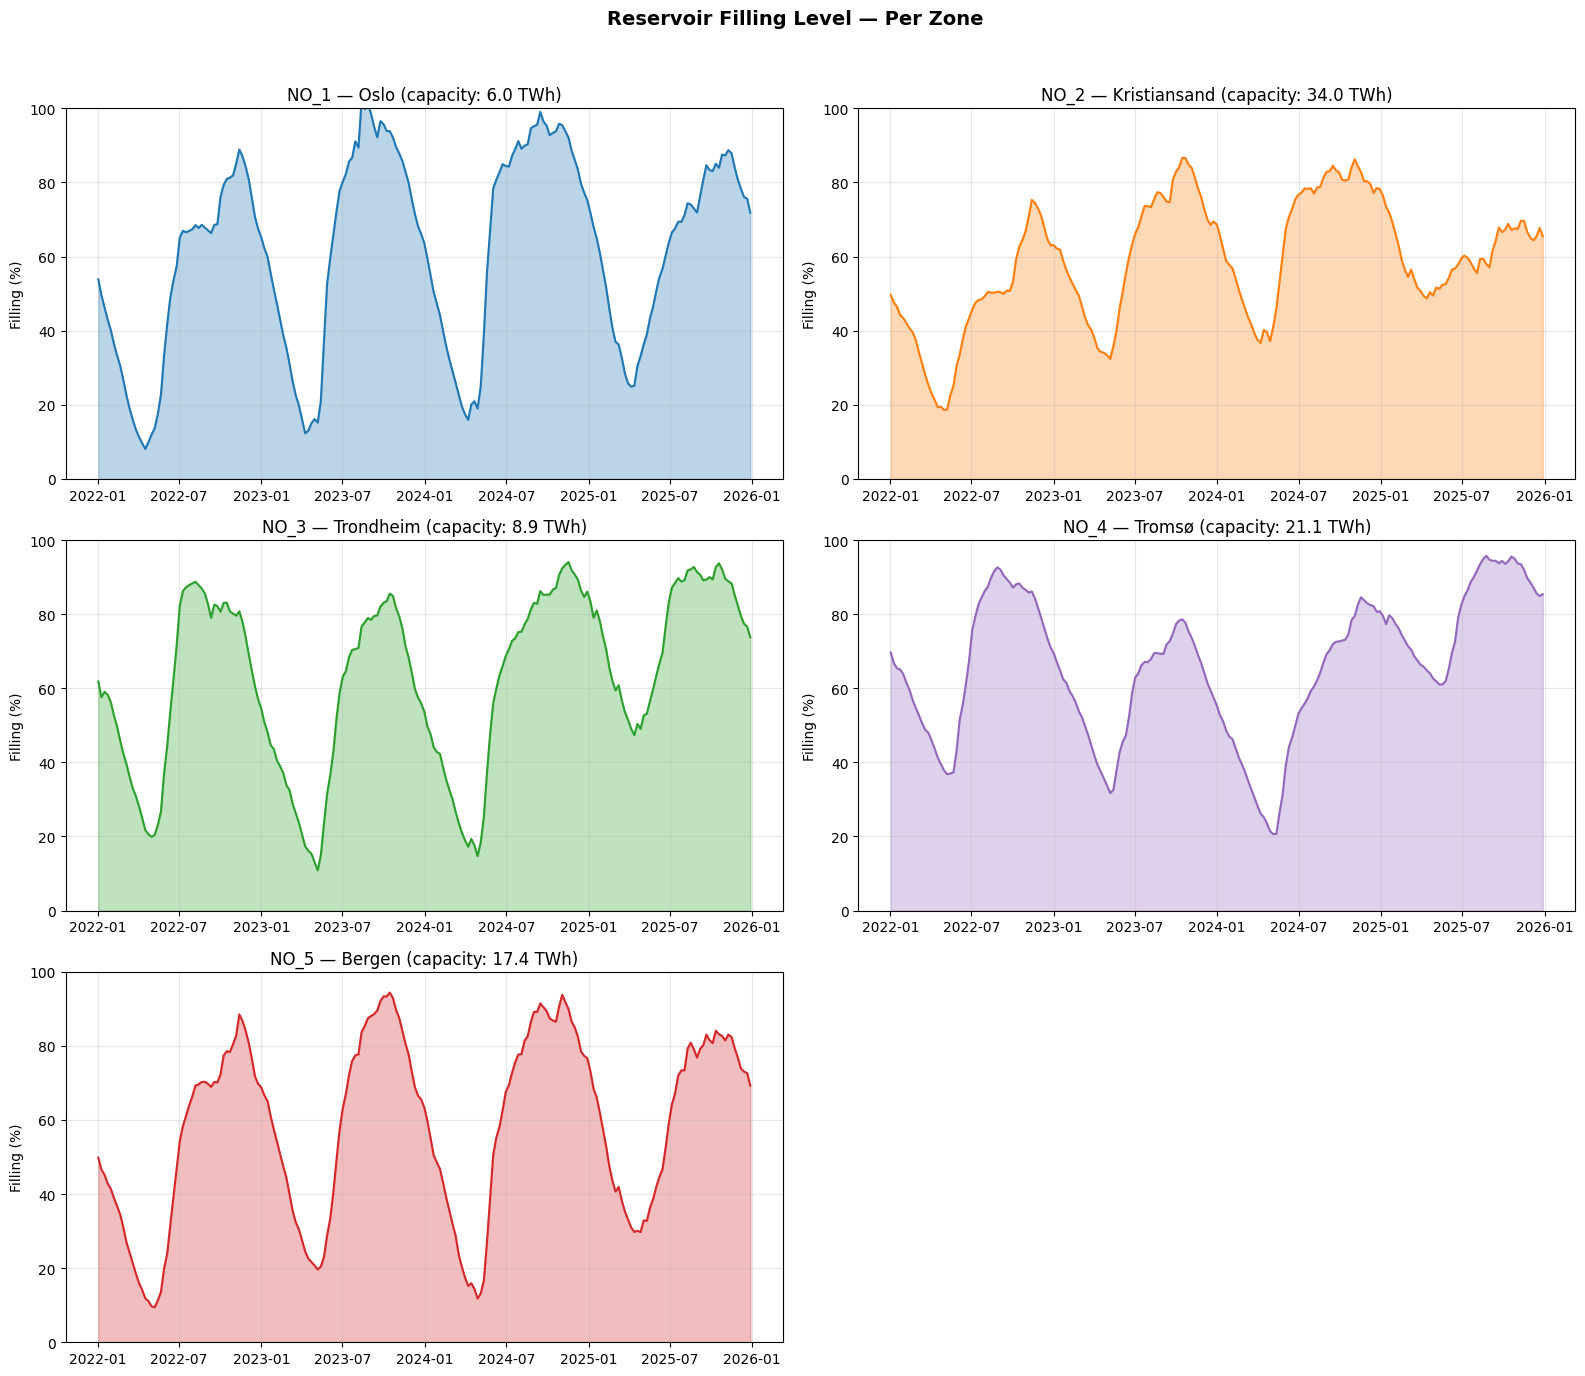

When reservoirs drop below the 20yr median (dashed), prices tend to rise.
The 2022 drawdown hit southern zones (NO_2, NO_5) hardest.


In [7]:
# Reservoir filling — detailed per-zone view
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes_flat = axes.flatten()

for i, zone in enumerate(ZONES):
    ax = axes_flat[i]
    if zone in reservoir:
        df = reservoir[zone]
        ax.fill_between(df.index, 0, df["filling_pct"] * 100,
                       color=ZONE_COLORS[zone], alpha=0.3)
        ax.plot(df.index, df["filling_pct"] * 100,
                color=ZONE_COLORS[zone], linewidth=1.5)

        # Show median benchmark if available
        if "median_pct" in df.columns:
            ax.plot(df.index, df["median_pct"] * 100,
                    color="black", linewidth=1, linestyle="--", alpha=0.5,
                    label="20yr median")
            ax.legend(fontsize=8)

        capacity = df["capacity_twh"].iloc[-1] if "capacity_twh" in df.columns else "?"
        ax.set_title(f"{zone} — {ZONE_LABELS[zone]} (capacity: {capacity:.1f} TWh)")
    else:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(f"{zone} — {ZONE_LABELS[zone]}")

    ax.set_ylim(0, 100)
    ax.set_ylabel("Filling (%)")
    ax.grid(True, alpha=0.3)

# Hide the 6th subplot
axes_flat[5].set_visible(False)

fig.suptitle("Reservoir Filling Level — Per Zone", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("When reservoirs drop below the 20yr median (dashed), prices tend to rise.")
print("The 2022 drawdown hit southern zones (NO_2, NO_5) hardest.")

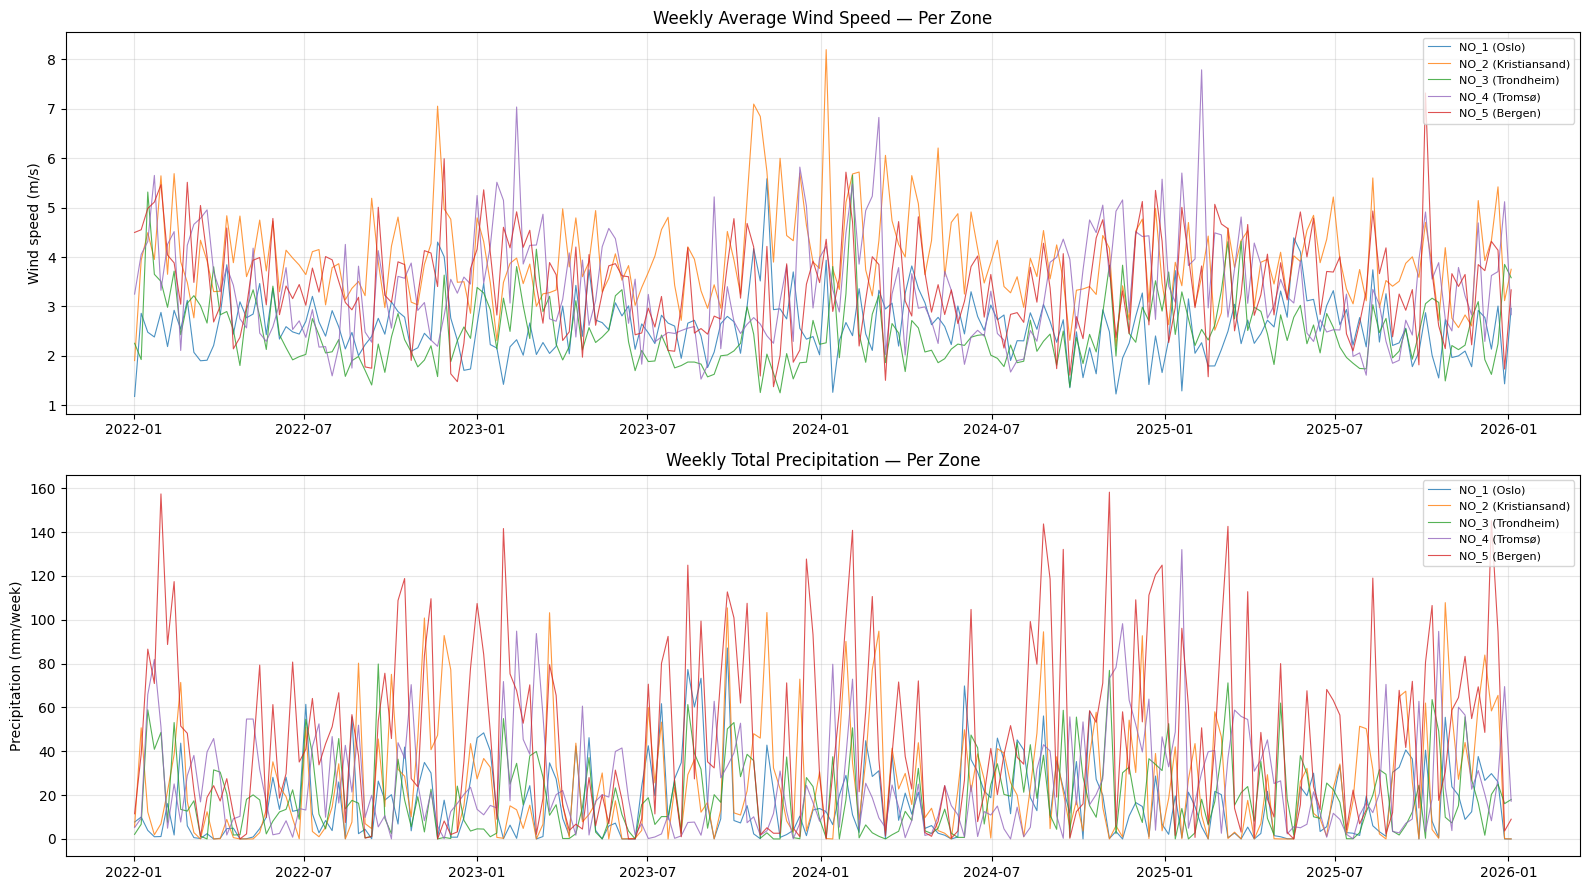

Bergen (NO_5) is the wettest — its reservoirs get the most recharge.
Coastal zones tend to be windier — more wind generation potential.


In [8]:
# Wind speed and precipitation — per zone supply indicators
fig, axes = plt.subplots(2, 1, figsize=(16, 9))

# Daily average wind speed
ax = axes[0]
for zone in ZONES:
    if zone in weather and "wind_speed" in weather[zone].columns:
        daily_wind = weather[zone]["wind_speed"].resample("W").mean()
        ax.plot(daily_wind.index, daily_wind.values,
                color=ZONE_COLORS[zone], linewidth=0.8, alpha=0.8,
                label=f"{zone} ({ZONE_LABELS[zone]})")
ax.set_ylabel("Wind speed (m/s)")
ax.set_title("Weekly Average Wind Speed — Per Zone")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

# Weekly total precipitation
ax = axes[1]
for zone in ZONES:
    if zone in weather and "precipitation" in weather[zone].columns:
        weekly_rain = weather[zone]["precipitation"].resample("W").sum()
        ax.plot(weekly_rain.index, weekly_rain.values,
                color=ZONE_COLORS[zone], linewidth=0.8, alpha=0.8,
                label=f"{zone} ({ZONE_LABELS[zone]})")
ax.set_ylabel("Precipitation (mm/week)")
ax.set_title("Weekly Total Precipitation — Per Zone")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Bergen (NO_5) is the wettest — its reservoirs get the most recharge.")
print("Coastal zones tend to be windier — more wind generation potential.")

---
## 3. Demand Side — Per Zone

Demand is driven by:
- **Temperature** — cold weather increases heating demand (the biggest driver)
- **Calendar** — weekdays have higher demand than weekends; mornings and evenings peak

### The temperature–demand relationship

Norway is unique: it uses **electric heating** (heat pumps, electric radiators) instead of gas central heating. This creates a direct, measurable link between temperature and electricity demand.

The standard metric is **Heating Degree Days (HDD)**:

$$\text{HDD} = \max(0,\; T_{\text{base}} - T_{\text{avg}})$$

where $T_{\text{base}} \approx 17\text{°C}$ (the threshold below which heating starts). For a day with average temperature 2°C:

$$\text{HDD} = 17 - 2 = 15 \text{ degree-days}$$

More HDD = more heating demand = higher electricity consumption = higher prices.

**Non-linearity**: The relationship isn't perfectly linear. Below about $-10\text{°C}$, heat pumps lose efficiency and switch to resistive heating, causing demand to increase **faster** than linearly. This is why extreme cold snaps cause disproportionate price spikes.

### Why temperature differs between zones

| Zone | Latitude | Climate | Winter character |
|------|----------|---------|------------------|
| NO_1 (Oslo) | 60°N | Continental | Cold winters (−10 to −20°C possible) |
| NO_2 (Kristiansand) | 58°N | Coastal mild | Mildest winters (rarely below −10°C) |
| NO_3 (Trondheim) | 63°N | Coastal/transitional | Moderate cold |
| NO_4 (Tromsø) | 69°N | Arctic | Long, cold winters (months below 0°C) |
| NO_5 (Bergen) | 60°N | Coastal wet | Mild but very wet |

### What the plots below show

Temperature time series per zone with **blue = below freezing** (high heating demand) and **red = above freezing** (low heating demand). NO_4 spends months in the blue zone — constant high heating demand.

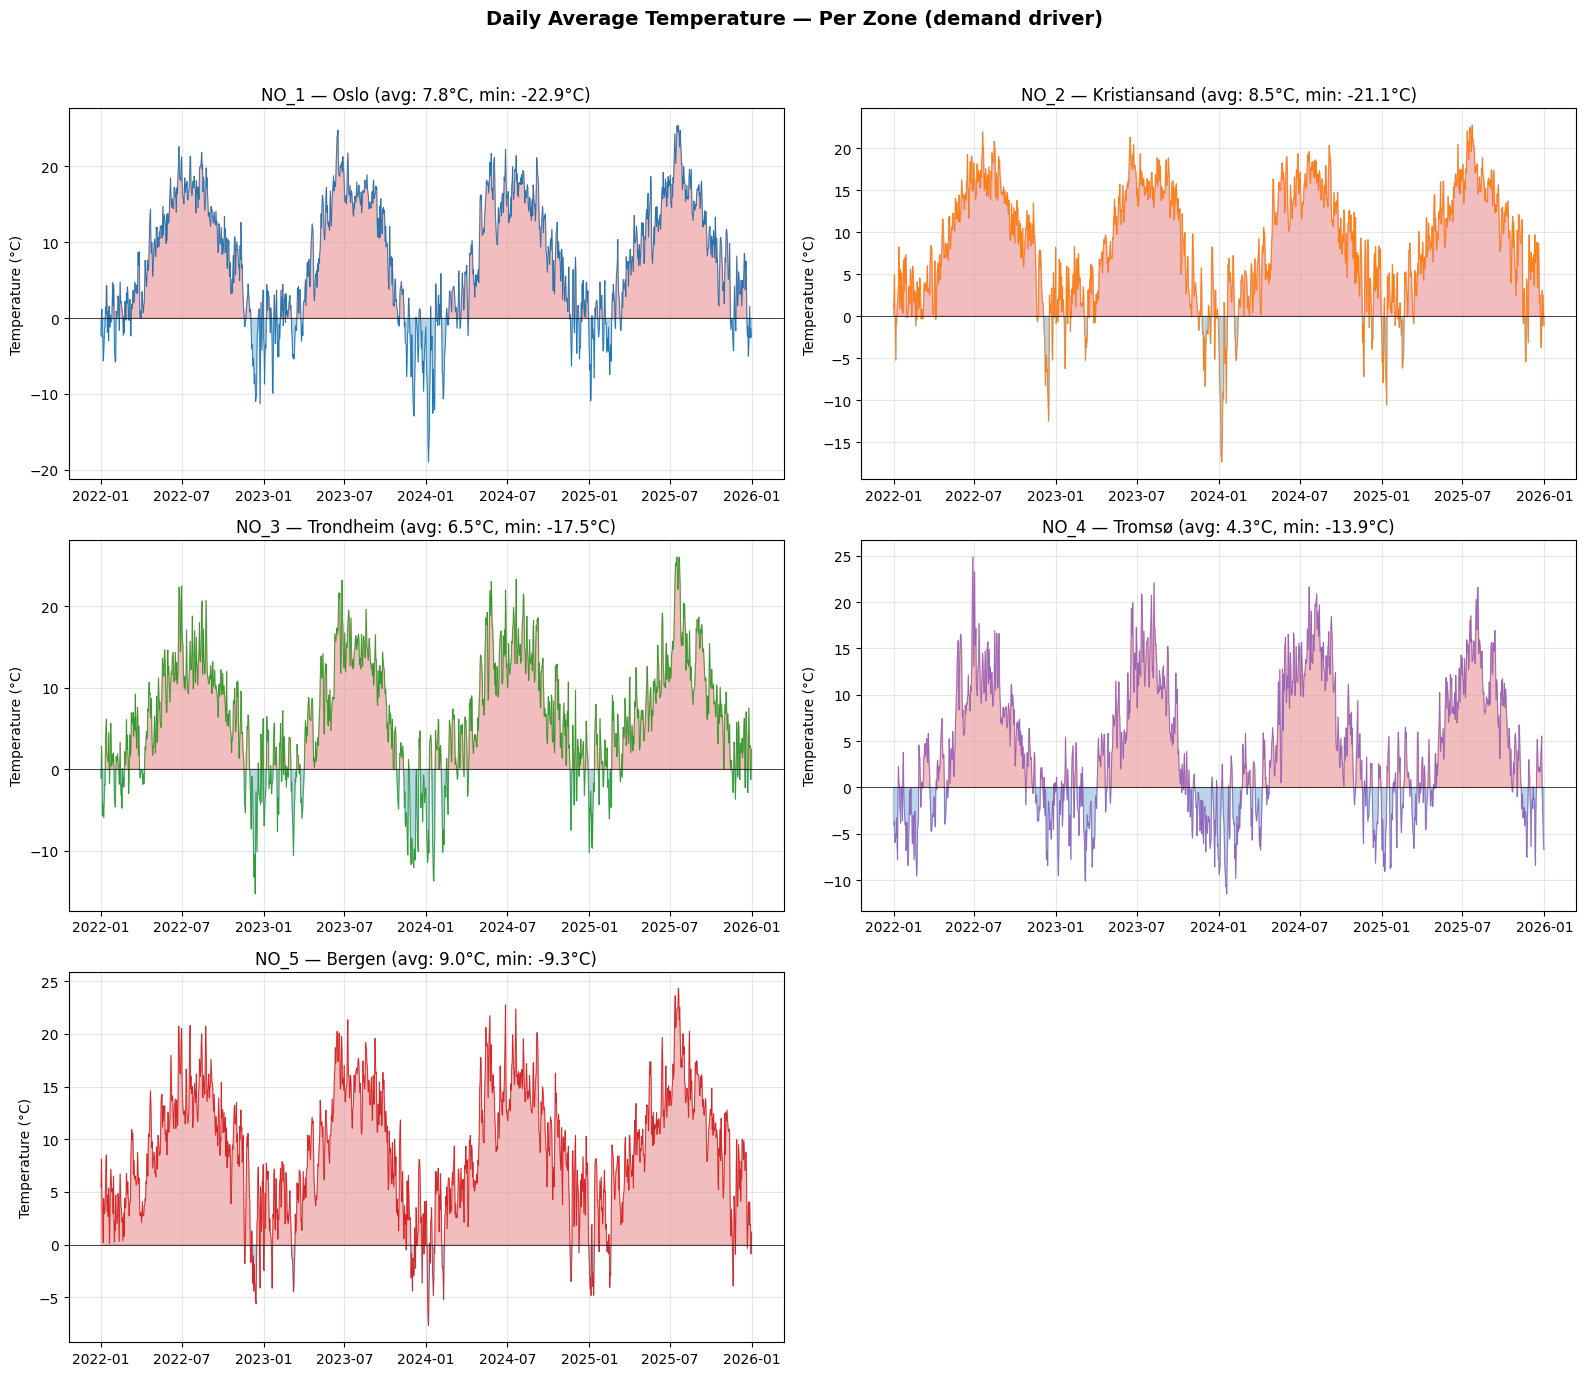

Blue area = below freezing → high heating demand → higher electricity prices
Tromsø (NO_4) spends months below zero — constant heating demand in winter.
Kristiansand (NO_2) has the mildest winters — less heating needed.


In [9]:
# Temperature — the primary demand driver
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes_flat = axes.flatten()

for i, zone in enumerate(ZONES):
    ax = axes_flat[i]
    if zone in weather and "air_temperature" in weather[zone].columns:
        temp = weather[zone]["air_temperature"]
        daily_temp = temp.resample("D").mean()

        # Color by temperature: blue for cold, red for warm
        ax.fill_between(daily_temp.index, 0, daily_temp.values,
                       where=daily_temp.values >= 0,
                       color="tab:red", alpha=0.3, interpolate=True)
        ax.fill_between(daily_temp.index, 0, daily_temp.values,
                       where=daily_temp.values < 0,
                       color="tab:blue", alpha=0.3, interpolate=True)
        ax.plot(daily_temp.index, daily_temp.values,
                color=ZONE_COLORS[zone], linewidth=0.6)

        avg = temp.mean()
        min_t = temp.min()
        ax.set_title(f"{zone} — {ZONE_LABELS[zone]} (avg: {avg:.1f}°C, min: {min_t:.1f}°C)")
    else:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(f"{zone} — {ZONE_LABELS[zone]}")

    ax.axhline(y=0, color="black", linewidth=0.5)
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, alpha=0.3)

axes_flat[5].set_visible(False)

fig.suptitle("Daily Average Temperature — Per Zone (demand driver)", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("Blue area = below freezing → high heating demand → higher electricity prices")
print("Tromsø (NO_4) spends months below zero — constant heating demand in winter.")
print("Kristiansand (NO_2) has the mildest winters — less heating needed.")

---
## 4. How Supply & Demand Drive Prices — Per Zone

Now the key question: **do prices actually respond to these supply/demand indicators?**

### Reading the scatter plots

Each scatter plot below shows one supply/demand variable (x-axis) vs price (y-axis). Each dot is one day. The black trend line shows the **binned average** (data is grouped into 12–15 bins, then averaged).

### Correlation coefficient ($r$)

Each plot title shows the **Pearson correlation coefficient**:

$$r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum(x_i - \bar{x})^2} \cdot \sqrt{y_i - \bar{y})^2}}$$

| $r$ value | Interpretation |
|-----------|----------------|
| $r \approx -0.3$ to $-0.5$ | Moderate negative — colder/lower reservoir → higher price |
| $r \approx -0.1$ to $-0.2$ | Weak negative — small but real effect |
| $r \approx 0$ | No linear relationship (but non-linear may still exist!) |

### Important: Correlation ≠ Causation

A correlation between temperature and price doesn't *prove* temperature causes price changes. There could be **confounders**:
- Both temperature and price follow seasonal patterns (winter = cold + expensive)
- European gas prices also peak in winter

To establish causality, we need **Granger causality tests** and **multivariate regression** — see notebook 08 for these statistical methods.

### What each scatter plot shows

| Plot | Expected relationship | Why |
|------|---------------------|-----|
| **Price vs Temperature** | Negative ($r < 0$) | Cold → more heating → higher demand → higher price |
| **Price vs Reservoir** | Negative ($r < 0$) | Low reservoir → less supply → higher price |
| **Price vs Wind** | Weak negative ($r \approx 0$) | More wind → more generation → slightly lower price (small effect in hydro-dominated Norway) |

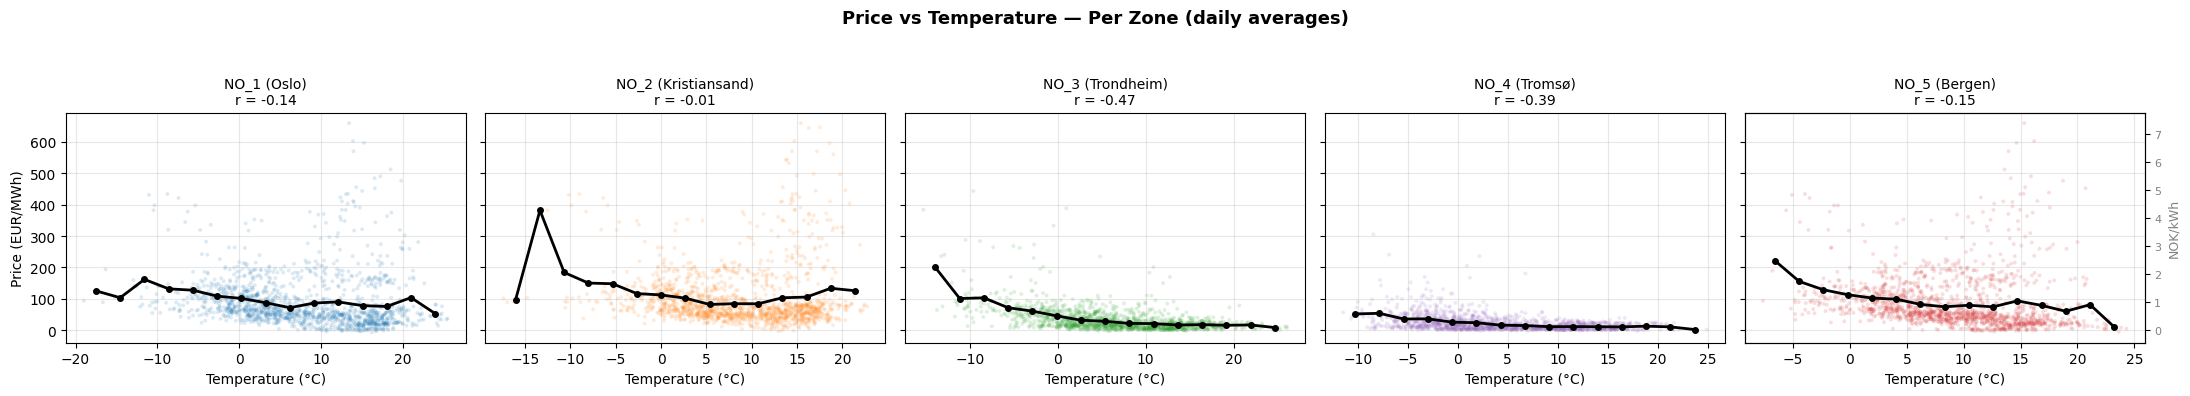

Negative correlation: colder → more expensive (heating demand drives price up).
The relationship is clearest in southern zones (NO_1, NO_2) connected to Europe.
NO_3/NO_4 show weaker correlation — they have surplus supply most of the time.
(Right y-axis shows NOK/kWh at avg EUR/NOK = 11.22)


In [10]:
# Price vs Temperature — per zone scatter
fig, axes = plt.subplots(1, 5, figsize=(22, 4), sharey=True)

for i, zone in enumerate(ZONES):
    ax = axes[i]
    if zone in weather and zone in prices.columns and "air_temperature" in weather[zone].columns:
        # Align on daily averages
        daily_temp = weather[zone]["air_temperature"].resample("D").mean()
        daily_price = prices[zone].resample("D").mean()
        combined = pd.DataFrame({"temp": daily_temp, "price": daily_price}).dropna()

        ax.scatter(combined["temp"], combined["price"],
                  color=ZONE_COLORS[zone], alpha=0.15, s=8, edgecolors="none")

        # Bin by temperature ranges and show trend
        bins = pd.cut(combined["temp"], bins=15)
        trend = combined.groupby(bins, observed=True)["price"].mean()
        bin_centers = [(b.left + b.right) / 2 for b in trend.index]
        ax.plot(bin_centers, trend.values, color="black", linewidth=2, marker="o", markersize=4)

        corr = combined["temp"].corr(combined["price"])
        ax.set_title(f"{zone} ({ZONE_LABELS[zone]})\nr = {corr:.2f}", fontsize=10)
    else:
        ax.set_title(f"{zone}\nNo data")

    ax.set_xlabel("Temperature (\u00b0C)")
    if i == 0:
        ax.set_ylabel("Price (EUR/MWh)")
    ax.grid(True, alpha=0.3)

# Add NOK/kWh axis to the rightmost plot
add_nok_axis(axes[-1])

fig.suptitle("Price vs Temperature — Per Zone (daily averages)", fontsize=13, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

print("Negative correlation: colder \u2192 more expensive (heating demand drives price up).")
print("The relationship is clearest in southern zones (NO_1, NO_2) connected to Europe.")
print("NO_3/NO_4 show weaker correlation \u2014 they have surplus supply most of the time.")
print(f"(Right y-axis shows NOK/kWh at avg EUR/NOK = {AVG_EUR_NOK:.2f})")

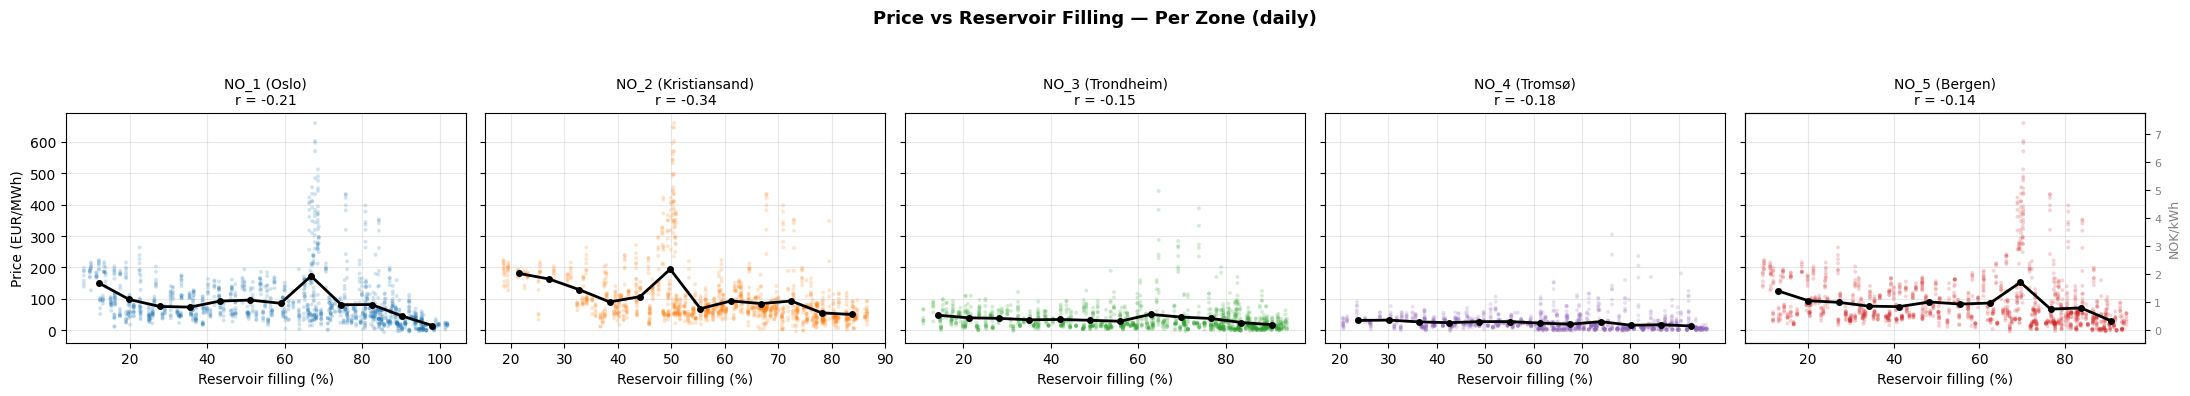

Negative correlation: fuller reservoirs → cheaper electricity (more supply available).
The effect is strongest in NO_2 and NO_5 which hold the most capacity.
(Right y-axis shows NOK/kWh at avg EUR/NOK = 11.22)


In [11]:
# Price vs Reservoir filling — per zone
fig, axes = plt.subplots(1, 5, figsize=(22, 4), sharey=True)

for i, zone in enumerate(ZONES):
    ax = axes[i]
    if zone in reservoir and zone in prices.columns:
        res = reservoir[zone]["filling_pct"].copy()
        # Forward-fill weekly reservoir to daily
        daily_price = prices[zone].resample("D").mean()
        res_daily = res.resample("D").ffill()

        combined = pd.DataFrame({"reservoir": res_daily, "price": daily_price}).dropna()

        ax.scatter(combined["reservoir"] * 100, combined["price"],
                  color=ZONE_COLORS[zone], alpha=0.2, s=8, edgecolors="none")

        # Trend line
        bins = pd.cut(combined["reservoir"], bins=12)
        trend = combined.groupby(bins, observed=True)["price"].mean()
        bin_centers = [(b.left + b.right) / 2 * 100 for b in trend.index]
        ax.plot(bin_centers, trend.values, color="black", linewidth=2, marker="o", markersize=4)

        corr = combined["reservoir"].corr(combined["price"])
        ax.set_title(f"{zone} ({ZONE_LABELS[zone]})\nr = {corr:.2f}", fontsize=10)
    else:
        ax.set_title(f"{zone}\nNo data")

    ax.set_xlabel("Reservoir filling (%)")
    if i == 0:
        ax.set_ylabel("Price (EUR/MWh)")
    ax.grid(True, alpha=0.3)

# Add NOK/kWh axis to the rightmost plot
add_nok_axis(axes[-1])

fig.suptitle("Price vs Reservoir Filling \u2014 Per Zone (daily)", fontsize=13, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

print("Negative correlation: fuller reservoirs \u2192 cheaper electricity (more supply available).")
print("The effect is strongest in NO_2 and NO_5 which hold the most capacity.")
print(f"(Right y-axis shows NOK/kWh at avg EUR/NOK = {AVG_EUR_NOK:.2f})")

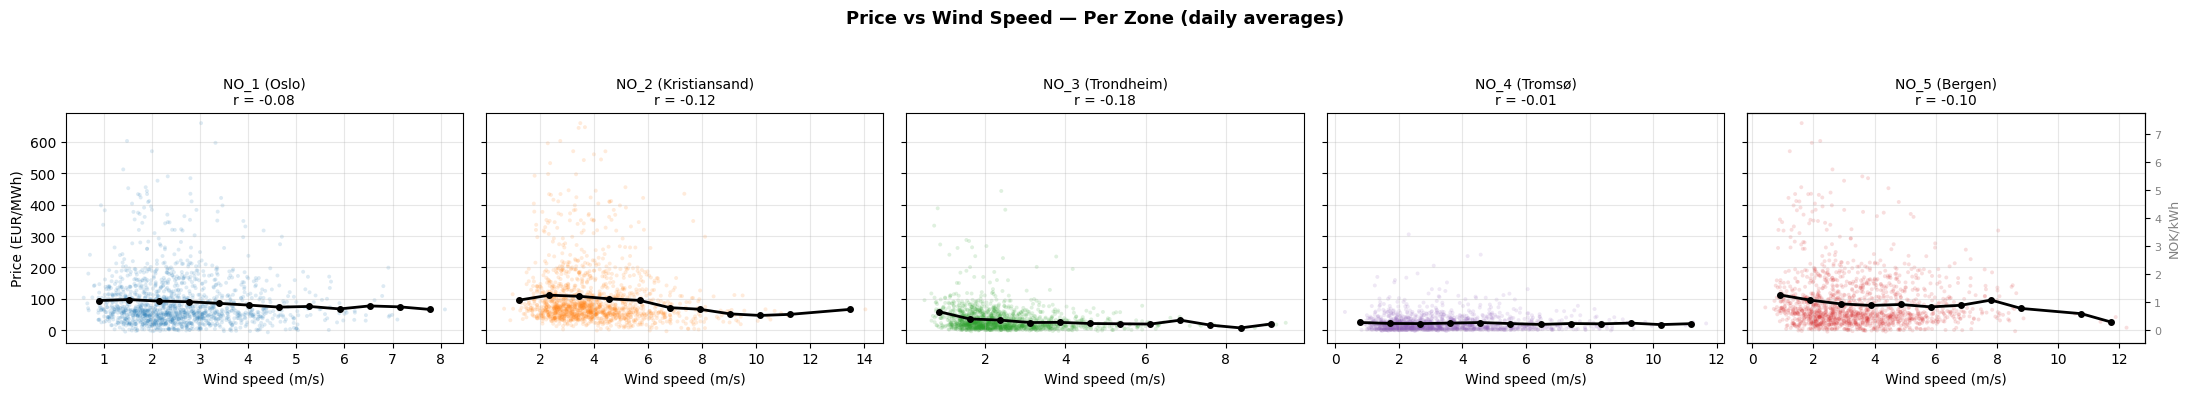

Weak negative correlation: more wind → slightly lower prices (extra generation).
Wind effect is weaker than temperature or reservoir — Norway is mostly hydro, not wind.
(Right y-axis shows NOK/kWh at avg EUR/NOK = 11.22)


In [12]:
# Price vs Wind — per zone
fig, axes = plt.subplots(1, 5, figsize=(22, 4), sharey=True)

for i, zone in enumerate(ZONES):
    ax = axes[i]
    if zone in weather and zone in prices.columns and "wind_speed" in weather[zone].columns:
        daily_wind = weather[zone]["wind_speed"].resample("D").mean()
        daily_price = prices[zone].resample("D").mean()
        combined = pd.DataFrame({"wind": daily_wind, "price": daily_price}).dropna()

        ax.scatter(combined["wind"], combined["price"],
                  color=ZONE_COLORS[zone], alpha=0.15, s=8, edgecolors="none")

        bins = pd.cut(combined["wind"], bins=12)
        trend = combined.groupby(bins, observed=True)["price"].mean()
        bin_centers = [(b.left + b.right) / 2 for b in trend.index]
        ax.plot(bin_centers, trend.values, color="black", linewidth=2, marker="o", markersize=4)

        corr = combined["wind"].corr(combined["price"])
        ax.set_title(f"{zone} ({ZONE_LABELS[zone]})\nr = {corr:.2f}", fontsize=10)
    else:
        ax.set_title(f"{zone}\nNo data")

    ax.set_xlabel("Wind speed (m/s)")
    if i == 0:
        ax.set_ylabel("Price (EUR/MWh)")
    ax.grid(True, alpha=0.3)

# Add NOK/kWh axis to the rightmost plot
add_nok_axis(axes[-1])

fig.suptitle("Price vs Wind Speed \u2014 Per Zone (daily averages)", fontsize=13, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

print("Weak negative correlation: more wind \u2192 slightly lower prices (extra generation).")
print("Wind effect is weaker than temperature or reservoir \u2014 Norway is mostly hydro, not wind.")
print(f"(Right y-axis shows NOK/kWh at avg EUR/NOK = {AVG_EUR_NOK:.2f})")

---
## 5. Why Do Zones Get Different Prices?

Zones decouple when **transmission capacity** between them is congested.

### Locational Marginal Pricing (LMP)

Norway (like all Nord Pool countries) uses **zonal pricing**: the country is divided into 5 bidding zones, and each zone gets its own price when transmission between zones is constrained.

$$P_{\text{zone}} = P_{\text{system}} + \text{congestion rent}_{\text{zone}}$$

where:
- $P_{\text{system}}$ = the price if there were unlimited transmission (single market)
- **Congestion rent** = premium paid because transmission bottlenecks prevent power from flowing freely

When transmission is **not** congested, all zones have the same price. When it **is** congested, zones with surplus supply (north) are cheaper and zones with deficit (south, connected to Europe) are more expensive.

### Norway's transmission topology

```
              NO_4 (Tromsoe) — cheap, isolated, surplus hydro
                |  (limited capacity south)
              NO_3 (Trondheim) — cheap, good hydro
              / \  (bottleneck here)
  NO_5 (Bergen)    NO_1 (Oslo) — moderate, capital demand center
         \        /
         NO_2 (Kristiansand) — expensive, many EU cables
           | | | |
         Cables: DK, NL, DE, GB
```

The key bottleneck is between NO_3/NO_4 (north) and NO_1/NO_2/NO_5 (south). When European prices are high, cables export cheap Norwegian hydro → southern prices rise → but northern prices stay low because the transmission capacity north→south is limited.

### Price spread analysis

The plots below show **price spreads** between zone pairs:

$$\text{Spread}_{A,B} = P_A - P_B$$

- **Positive spread**: Zone A is more expensive than Zone B
- **Persistent positive spread**: Structural congestion — A consistently pays more
- **Mean-reverting spread**: Temporary congestion — prices equalize when grid relaxes

The correlation matrix shows how tightly zone prices move together. High correlation ($r > 0.9$) means zones are usually connected. Low correlation ($r < 0.7$) means they frequently decouple.

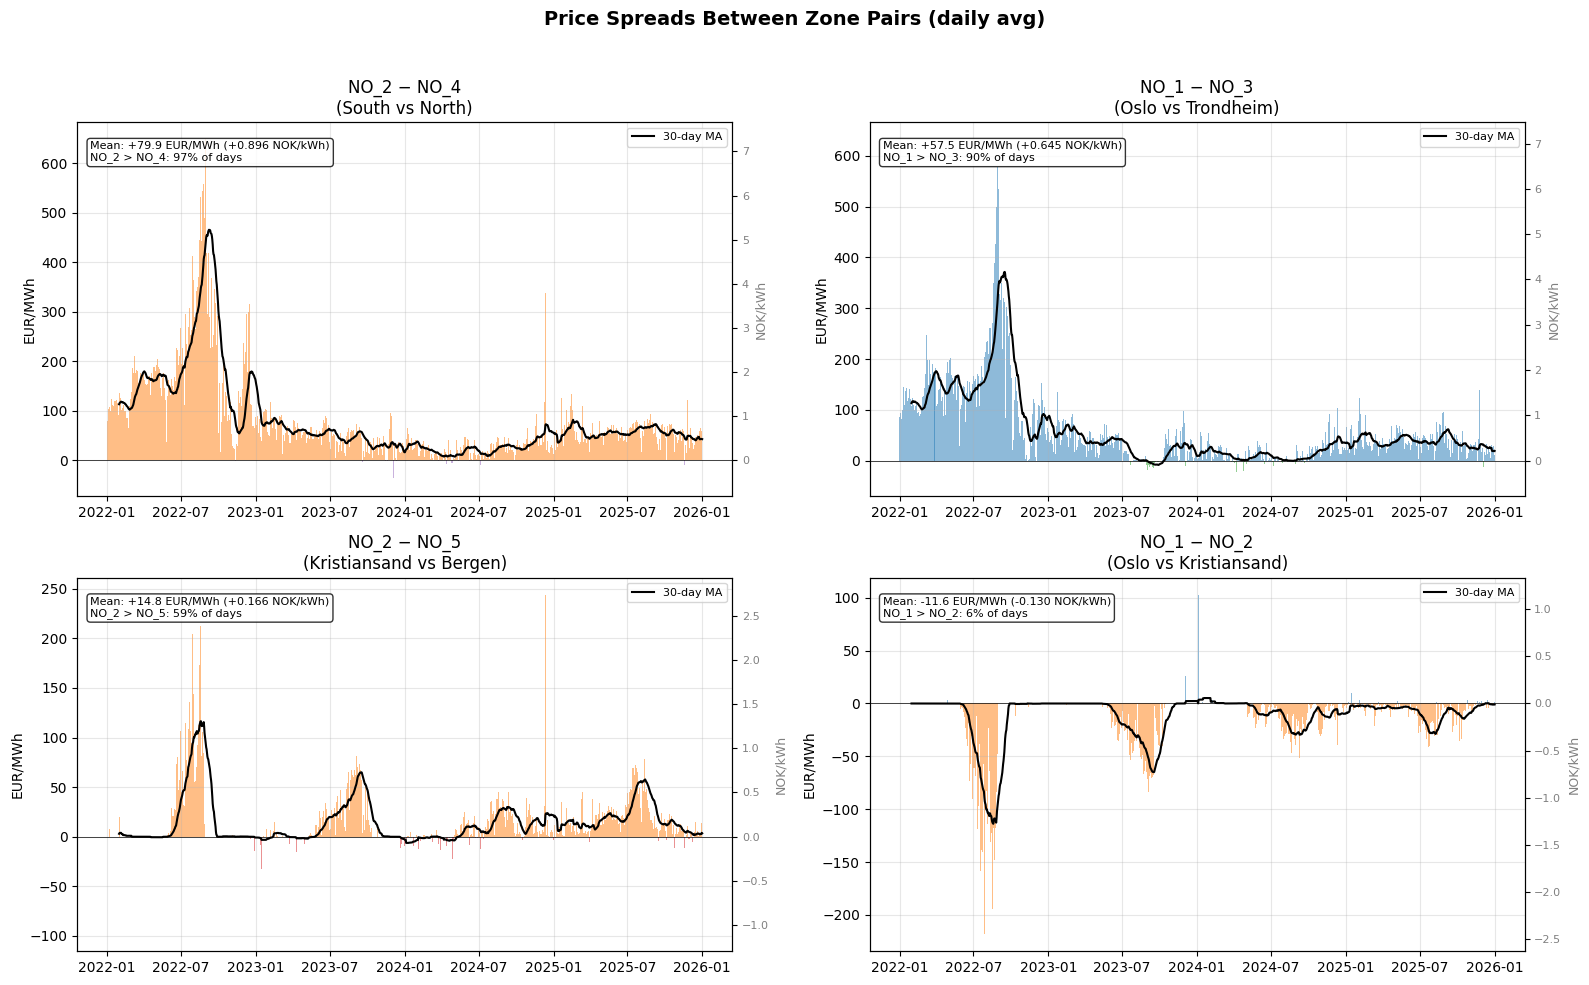

FINDING: The South-North split (NO_2 vs NO_4) is the biggest and most persistent.
NO_2 is expensive because cables to DK, NL, DE, and GB export cheap Norwegian hydro.
NO_4 stays cheap because it has surplus hydro and limited cables south.


In [13]:
# Price spread between key zone pairs
spreads = {
    "NO_2 \u2212 NO_4\n(South vs North)": ("NO_2", "NO_4"),
    "NO_1 \u2212 NO_3\n(Oslo vs Trondheim)": ("NO_1", "NO_3"),
    "NO_2 \u2212 NO_5\n(Kristiansand vs Bergen)": ("NO_2", "NO_5"),
    "NO_1 \u2212 NO_2\n(Oslo vs Kristiansand)": ("NO_1", "NO_2"),
}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes_flat = axes.flatten()

for i, (label, (z1, z2)) in enumerate(spreads.items()):
    ax = axes_flat[i]
    if z1 in daily_prices.columns and z2 in daily_prices.columns:
        diff = daily_prices[z1] - daily_prices[z2]
        colors = np.where(diff > 0, ZONE_COLORS[z1], ZONE_COLORS[z2])

        ax.bar(diff.index, diff.values, width=1, color=colors, alpha=0.5)
        ax.plot(diff.index, diff.rolling(30).mean(),
                color="black", linewidth=1.5, label="30-day MA")
        ax.axhline(y=0, color="black", linewidth=0.5)
        ax.set_ylabel("EUR/MWh")
        ax.set_title(label)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

        avg = diff.mean()
        avg_nok = avg * AVG_EUR_NOK / 1000
        pct_positive = (diff > 0).mean() * 100
        ax.text(0.02, 0.95,
                f"Mean: {avg:+.1f} EUR/MWh ({avg_nok:+.3f} NOK/kWh)\n{z1} > {z2}: {pct_positive:.0f}% of days",
                transform=ax.transAxes, fontsize=8, verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

        add_nok_axis(ax)

fig.suptitle("Price Spreads Between Zone Pairs (daily avg)", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("FINDING: The South-North split (NO_2 vs NO_4) is the biggest and most persistent.")
print("NO_2 is expensive because cables to DK, NL, DE, and GB export cheap Norwegian hydro.")
print("NO_4 stays cheap because it has surplus hydro and limited cables south.")

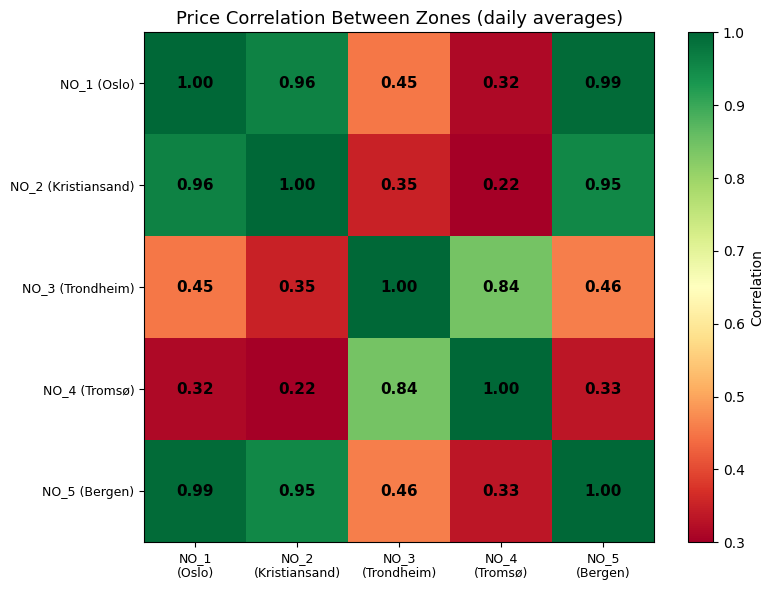

NO_1, NO_2, NO_5 are tightly correlated — connected via internal transmission.
NO_3 and NO_4 form a separate group — the North.
NO_4 has the lowest correlation with all other zones — most isolated.


In [14]:
# Price correlation between zones — how tightly coupled are they?
available = [z for z in ZONES if z in prices.columns]
daily_corr = daily_prices[available].corr()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(daily_corr.values, cmap="RdYlGn", vmin=0.3, vmax=1)
ax.set_xticks(range(len(available)))
ax.set_yticks(range(len(available)))
ax.set_xticklabels([f"{z}\n({ZONE_LABELS[z]})" for z in available], fontsize=9)
ax.set_yticklabels([f"{z} ({ZONE_LABELS[z]})" for z in available], fontsize=9)

for i in range(len(available)):
    for j in range(len(available)):
        ax.text(j, i, f"{daily_corr.iloc[i, j]:.2f}",
                ha="center", va="center", fontsize=11, fontweight="bold")

plt.colorbar(im, label="Correlation")
ax.set_title("Price Correlation Between Zones (daily averages)", fontsize=13)
plt.tight_layout()
plt.show()

print("NO_1, NO_2, NO_5 are tightly correlated — connected via internal transmission.")
print("NO_3 and NO_4 form a separate group — the North.")
print("NO_4 has the lowest correlation with all other zones — most isolated.")

---
## 6. Zone Dashboard — Supply & Demand at a Glance

One chart per zone: price (top), reservoir (middle), temperature (bottom).

### How to read the dashboard

Each row is one zone. The three columns show:

| Column | Variable | Role | What to look for |
|--------|----------|------|------------------|
| **Left** | Price (EUR/MWh, NOK/kWh) | The target variable | Spikes, seasonal patterns, 2022 crisis |
| **Middle** | Reservoir filling (%) | Supply indicator | Annual fill/drain cycle, 20yr median (dashed) |
| **Right** | Temperature (°C) | Demand indicator | Below-zero periods (blue) = high heating demand |

### Patterns to spot

1. **Price spikes align with low reservoirs AND cold temperatures** — the double whammy of high demand + low supply
2. **2022 energy crisis**: Prices spiked in southern zones (NO_1, NO_2, NO_5) but stayed low in the north — a clear congestion-driven divergence
3. **NO_4 (Tromsø)**: Coldest temperatures but lowest prices — because it has surplus hydro and can't export much south
4. **NO_2 (Kristiansand)**: Not the coldest but most expensive — because EU cables drain supply

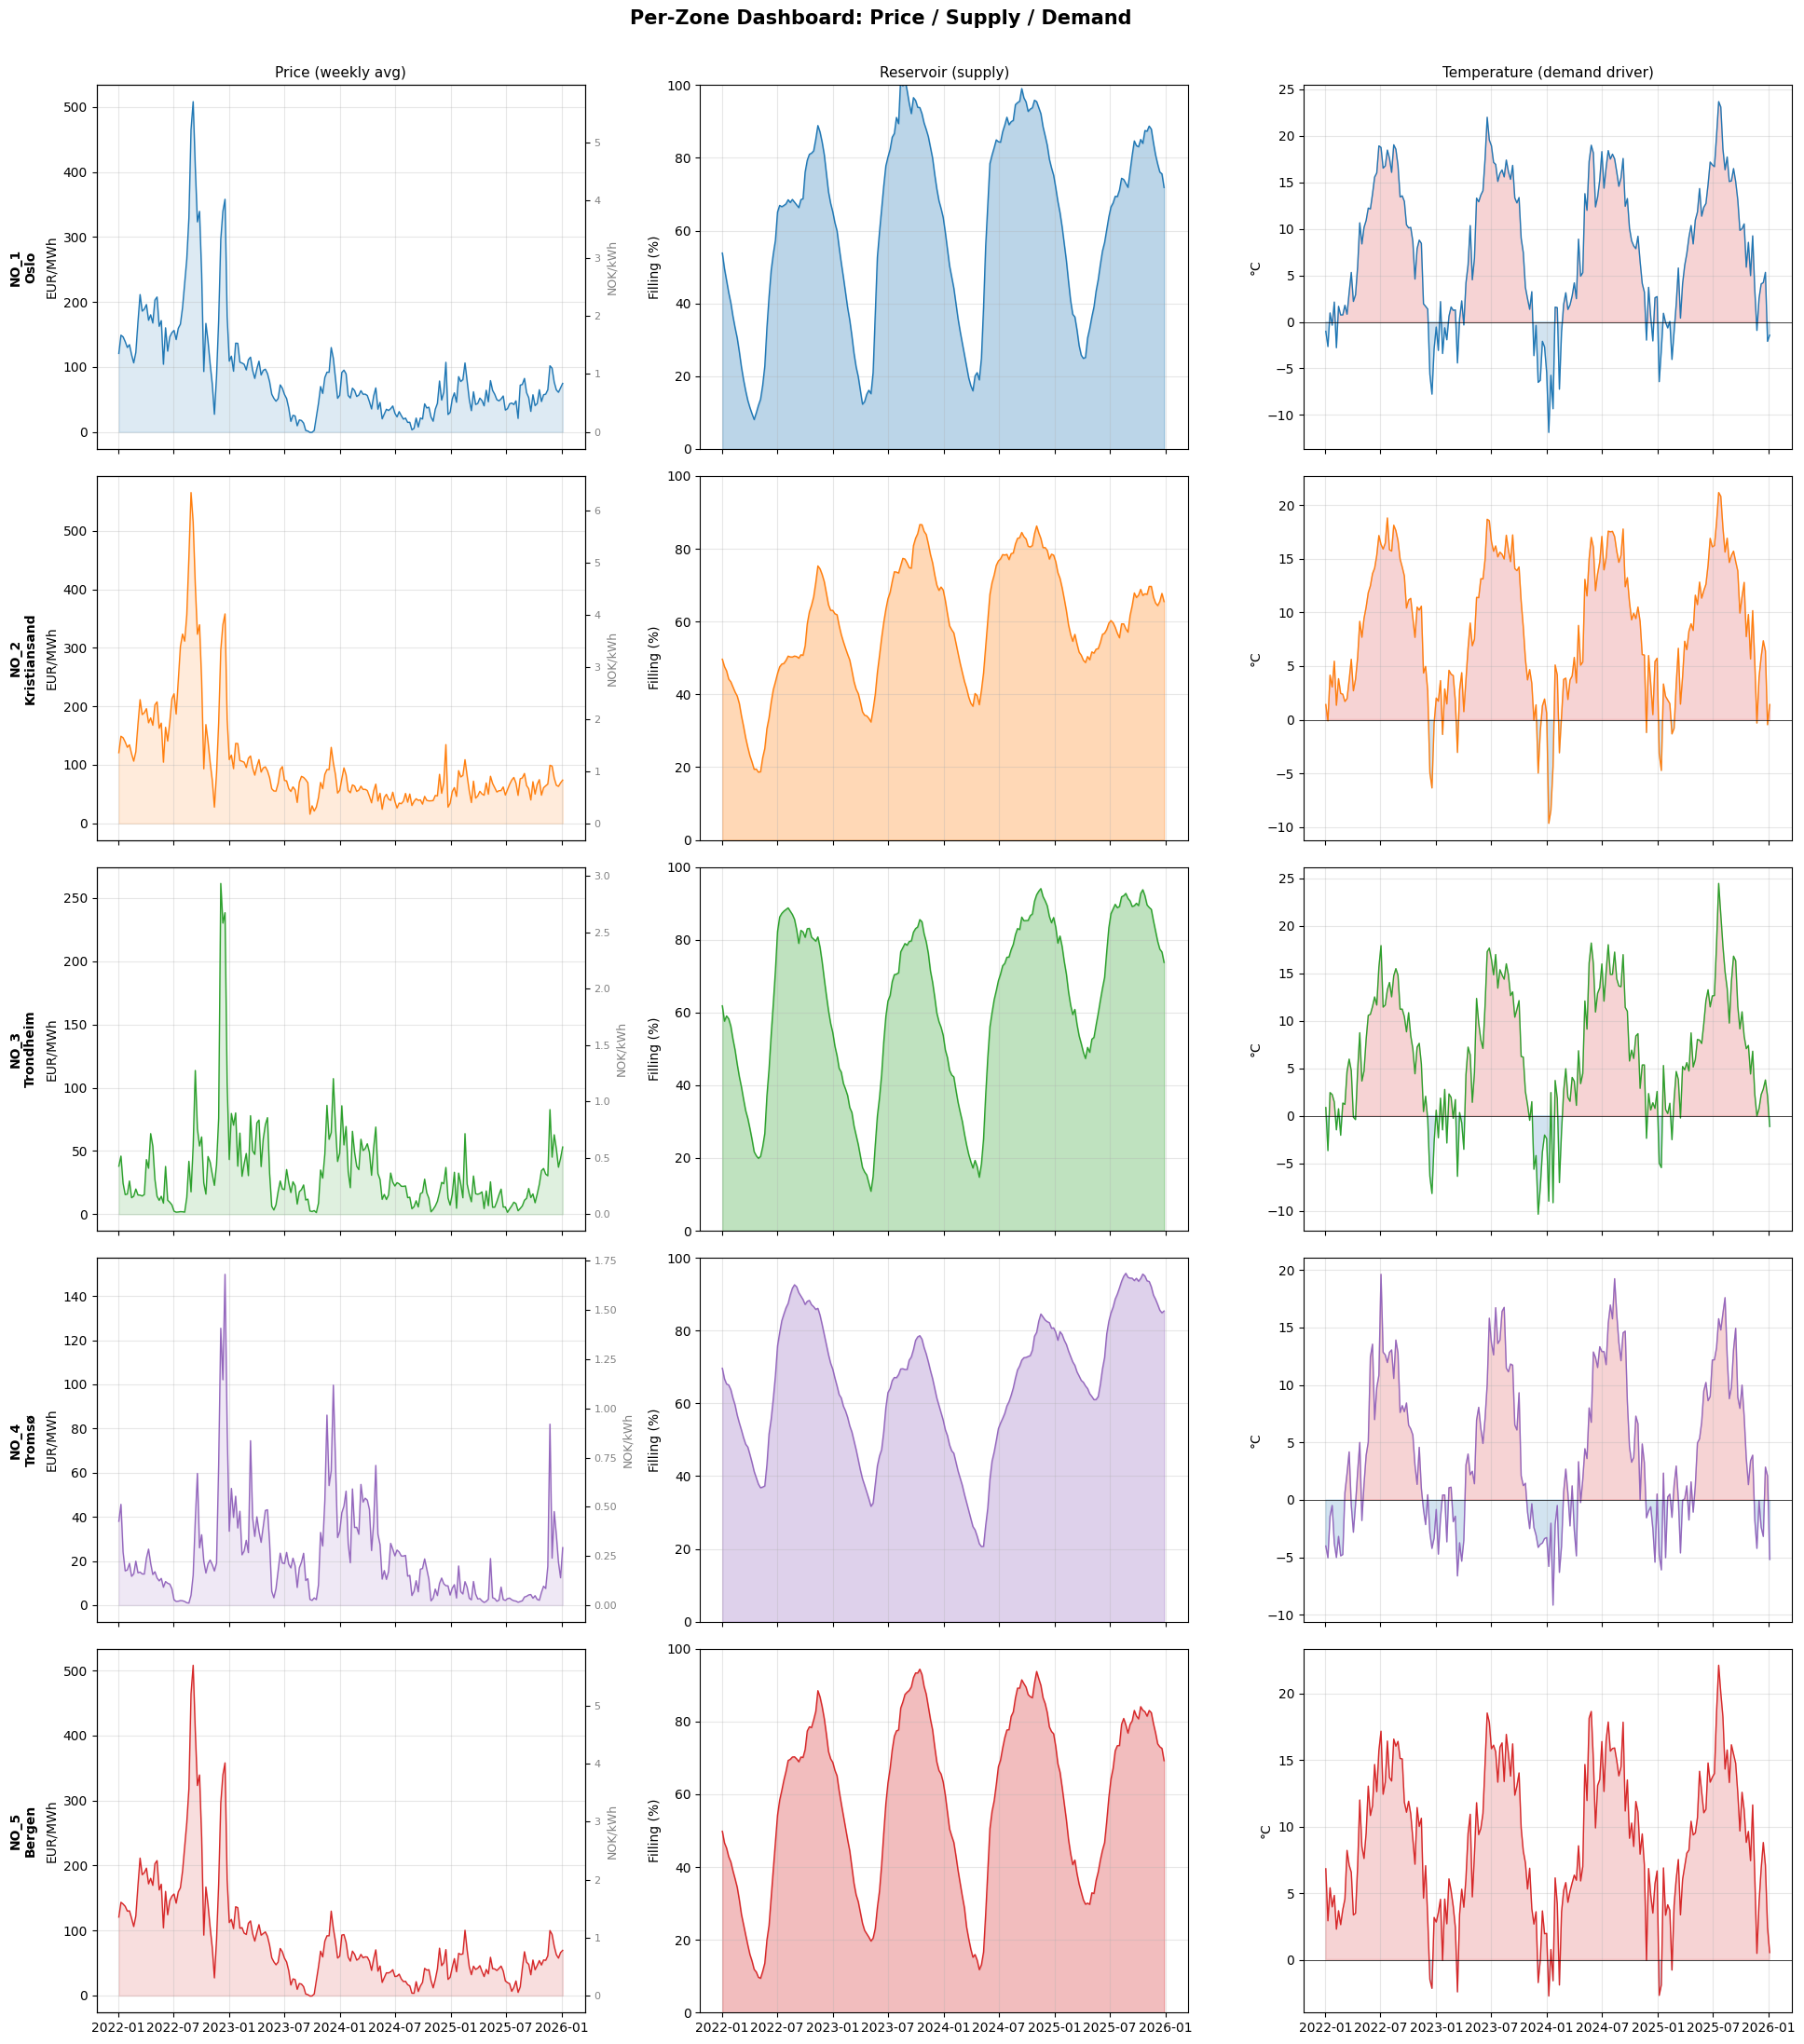

Read each row left→right: price is the outcome, reservoir is supply, temperature is demand.
When reservoir is low AND temperature is cold → price spikes.
(Right y-axis on price column shows NOK/kWh at avg EUR/NOK = 11.22)


In [15]:
fig, axes = plt.subplots(5, 3, figsize=(20, 22), sharex=True)

for i, zone in enumerate(ZONES):
    color = ZONE_COLORS[zone]

    # Column 0: Price
    ax = axes[i, 0]
    if zone in prices.columns:
        dp = prices[zone].resample("W").mean()
        ax.plot(dp.index, dp.values, color=color, linewidth=1)
        ax.fill_between(dp.index, 0, dp.values, color=color, alpha=0.15)
    ax.set_ylabel("EUR/MWh")
    if i == 0:
        ax.set_title("Price (weekly avg)", fontsize=11)
    ax.text(-0.15, 0.5, f"{zone}\n{ZONE_LABELS[zone]}",
            transform=ax.transAxes, fontsize=10, fontweight="bold",
            va="center", ha="center", rotation=90)
    ax.grid(True, alpha=0.3)
    add_nok_axis(ax)

    # Column 1: Reservoir
    ax = axes[i, 1]
    if zone in reservoir:
        df = reservoir[zone]
        ax.fill_between(df.index, 0, df["filling_pct"] * 100, color=color, alpha=0.3)
        ax.plot(df.index, df["filling_pct"] * 100, color=color, linewidth=1)
        if "median_pct" in df.columns:
            ax.plot(df.index, df["median_pct"] * 100,
                    color="black", linewidth=0.8, linestyle="--", alpha=0.5)
    ax.set_ylim(0, 100)
    ax.set_ylabel("Filling (%)")
    if i == 0:
        ax.set_title("Reservoir (supply)", fontsize=11)
    ax.grid(True, alpha=0.3)

    # Column 2: Temperature
    ax = axes[i, 2]
    if zone in weather and "air_temperature" in weather[zone].columns:
        temp = weather[zone]["air_temperature"].resample("W").mean()
        ax.fill_between(temp.index, 0, temp.values,
                       where=temp.values >= 0, color="tab:red", alpha=0.2, interpolate=True)
        ax.fill_between(temp.index, 0, temp.values,
                       where=temp.values < 0, color="tab:blue", alpha=0.2, interpolate=True)
        ax.plot(temp.index, temp.values, color=color, linewidth=1)
    ax.axhline(y=0, color="black", linewidth=0.5)
    ax.set_ylabel("°C")
    if i == 0:
        ax.set_title("Temperature (demand driver)", fontsize=11)
    ax.grid(True, alpha=0.3)

fig.suptitle("Per-Zone Dashboard: Price / Supply / Demand",
             fontsize=15, fontweight="bold", y=0.995)
plt.tight_layout(rect=[0.03, 0, 1, 0.99])
plt.show()

print("Read each row left→right: price is the outcome, reservoir is supply, temperature is demand.")
print("When reservoir is low AND temperature is cold → price spikes.")
print(f"(Right y-axis on price column shows NOK/kWh at avg EUR/NOK = {AVG_EUR_NOK:.2f})")

---
## 7. Summary

### Consumer Perspective (NOK/kWh)

Norwegian consumers see electricity prices in NOK/kWh on their bills. The conversion from market prices:

```
price_nok_kwh = price_eur_mwh x eur_nok / 1000
```

Typical consumer price range: 0.10-2.00 NOK/kWh (before grid fees, taxes, and subsidies). The government's electricity support scheme kicks in when monthly average exceeds ~0.70 NOK/kWh.

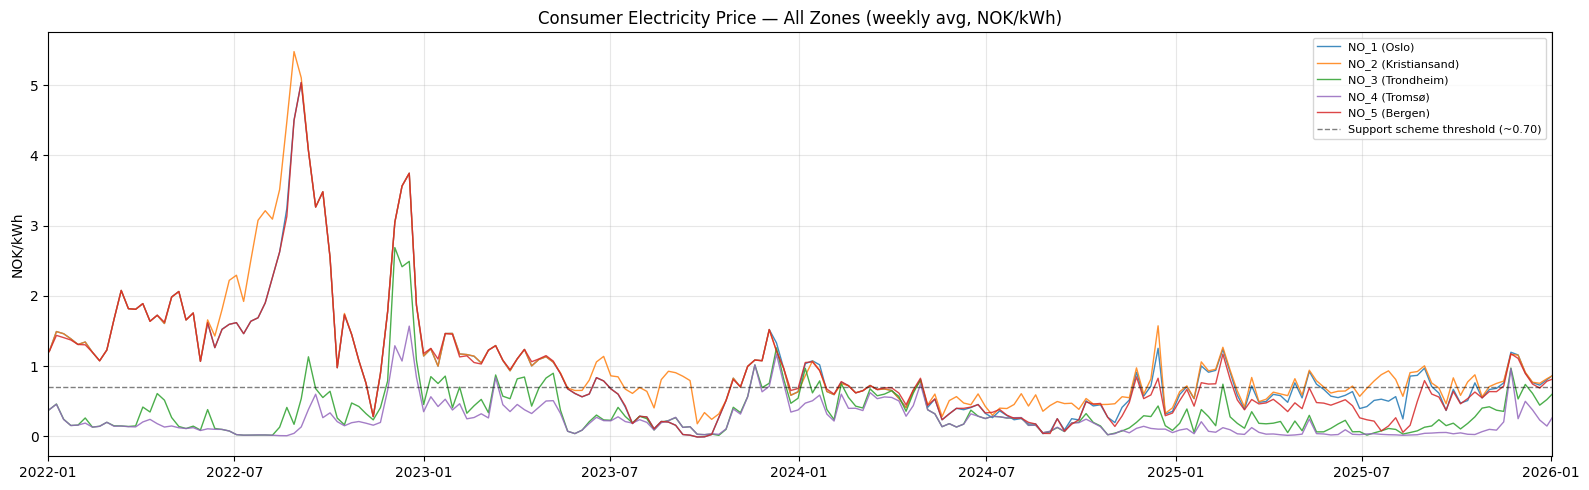

Dashed line: approximate threshold for Norway's electricity support scheme.
Southern zones regularly exceeded the threshold during the 2022 energy crisis.


In [16]:
# Consumer perspective: NOK/kWh per zone
from src.data.fetch_fx import fetch_eur_nok_daily_filled

fx_data = fetch_eur_nok_daily_filled(START, END, cache=True)

fig, ax = plt.subplots(figsize=(16, 5))

for zone in ZONES:
    if zone in prices.columns:
        daily_price = prices[zone].resample("D").mean()
        # Strip tz from daily_price to align with tz-naive FX data
        dp_naive = daily_price.copy()
        if dp_naive.index.tz is not None:
            dp_naive.index = dp_naive.index.tz_localize(None)
        fx_aligned = fx_data["eur_nok"].reindex(dp_naive.index, method="ffill")
        nok_kwh = dp_naive * fx_aligned / 1000
        weekly = nok_kwh.resample("W").mean()
        ax.plot(weekly.index, weekly.values,
                color=ZONE_COLORS[zone], linewidth=1, alpha=0.85,
                label=f"{zone} ({ZONE_LABELS[zone]})")

ax.axhline(y=0.70, color="black", linewidth=1, linestyle="--", alpha=0.5,
           label="Support scheme threshold (~0.70)")
ax.set_ylabel("NOK/kWh")
ax.set_title("Consumer Electricity Price — All Zones (weekly avg, NOK/kWh)")
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_xlim(prices.index.min(), prices.index.max())

plt.tight_layout()
plt.show()

print("Dashed line: approximate threshold for Norway's electricity support scheme.")
print("Southern zones regularly exceeded the threshold during the 2022 energy crisis.")

In [17]:
from src.data.fetch_fx import fetch_eur_nok_daily_filled

fx = fetch_eur_nok_daily_filled(START, END, cache=True)
avg_eur_nok = fx["eur_nok"].mean()

print("PER-ZONE SUPPLY & DEMAND SUMMARY")
print("=" * 110)
print(f"{'Zone':<8s} {'Region':<16s} {'EUR/MWh':>10s} {'NOK/MWh':>10s} {'NOK/kWh':>10s} {'Avg Temp':>10s} {'Avg Res.':>10s} {'Character'}")
print("-" * 110)

for zone in ZONES:
    region = ZONE_LABELS.get(zone, "")

    price_eur_str = "N/A"
    price_nok_mwh_str = "N/A"
    price_nok_kwh_str = "N/A"
    if zone in prices.columns:
        avg_eur = prices[zone].mean()
        avg_nok_mwh = avg_eur * avg_eur_nok
        avg_nok_kwh = avg_nok_mwh / 1000
        price_eur_str = f"{avg_eur:.1f}"
        price_nok_mwh_str = f"{avg_nok_mwh:.0f}"
        price_nok_kwh_str = f"{avg_nok_kwh:.3f}"

    temp_str = "N/A"
    if zone in weather and "air_temperature" in weather[zone].columns:
        temp_str = f"{weather[zone]['air_temperature'].mean():.1f}°C"

    res_str = "N/A"
    if zone in reservoir:
        res_str = f"{reservoir[zone]['filling_pct'].mean() * 100:.0f}%"

    char = {
        "NO_1": "Moderate price, capital demand center",
        "NO_2": "Highest price — EU cable exports drain supply",
        "NO_3": "Cheap — hydro surplus, limited cable exposure",
        "NO_4": "Cheapest — isolated, surplus hydro, Arctic cold",
        "NO_5": "Moderate — high rainfall refills reservoirs",
    }.get(zone, "")

    print(f"{zone:<8s} {region:<16s} {price_eur_str:>10s} {price_nok_mwh_str:>10s} {price_nok_kwh_str:>10s} {temp_str:>10s} {res_str:>10s} {char}")

print()
print(f"Average EUR/NOK rate in period: {avg_eur_nok:.2f}")
print(f"Conversion: price_nok_mwh = price_eur_mwh x {avg_eur_nok:.2f}, price_nok_kwh = price_nok_mwh / 1000")
print()
print("KEY FINDINGS:")
print("1. Two Norways: South (NO_1/NO_2/NO_5) has European prices; North (NO_3/NO_4) has cheap hydro.")
print("2. The price difference is driven by cable congestion — limited transmission north->south.")
print("3. Reservoir levels are the #1 supply signal: low reservoirs -> high prices.")
print("4. Temperature is the #1 demand signal: cold weather -> more heating -> higher demand.")
print("5. Wind has a weak but measurable effect on prices (more wind = slightly cheaper).")
print()
print("LIMITATION: Direct per-zone production & consumption data is not publicly available.")
print("Statnett publishes only national aggregates. ENTSO-E has per-zone load data (requires API key).")
print("For now, prices + reservoir + weather give a solid per-zone picture.")

PER-ZONE SUPPLY & DEMAND SUMMARY
Zone     Region              EUR/MWh    NOK/MWh    NOK/kWh   Avg Temp   Avg Res. Character
--------------------------------------------------------------------------------------------------------------
NO_1     Oslo                   89.9       1009      1.009      7.8°C        61% Moderate price, capital demand center
NO_2     Kristiansand          101.5       1139      1.139      8.5°C        59% Highest price — EU cable exports drain supply
NO_3     Trondheim              32.5        364      0.364      6.5°C        63% Cheap — hydro surplus, limited cable exposure
NO_4     Tromsø                 21.6        243      0.243      4.3°C        66% Cheapest — isolated, surplus hydro, Arctic cold
NO_5     Bergen                 86.7        973      0.973      9.0°C        58% Moderate — high rainfall refills reservoirs

Average EUR/NOK rate in period: 11.22
Conversion: price_nok_mwh = price_eur_mwh x 11.22, price_nok_kwh = price_nok_mwh / 1000

KEY FINDIN